In [ ]:
# ------------------------------------------------------- #
#                         MODULES                         #

# Standard Modules
import os

# Third Party Modules
import numpy as np
import geopandas as gpd
import pandas as pd
import plotly.express as px

# import pandas as pd
# import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------------- #
#                         FUNCTIONS                       #

###############################
# FPC Data Pipeline


# Dam Preprocessing Pipeline
def prepare_data(path, location_name):
    # Open Data
    df = pd.read_csv(path)

    # Filter to Dam Code
    df = df[df["Dam"].str.len() == 3]

    # Melt
    df_long = df.melt(
        id_vars=["Dam", "Date"],
        var_name="Species",
        value_name="Count",
    )

    # Remove Null Rows
    df_long = df_long.dropna(subset="Count")

    # Add Location Name
    df_long["Location"] = location_name

    # Aggregate
    df_long = df_long.groupby(["Dam", "Date", "Species", "Location"], as_index=False)[
        "Count"
    ].sum()

    # Make Date Type
    df_long["Datetime"] = pd.to_datetime(df_long["Date"])
    df_long["Date"] = df_long["Datetime"].dt.date
    df_long["DoY"] = df_long["Datetime"].dt.day_of_year
    df_long["WoY"] = df_long["Datetime"].dt.isocalendar().week
    df_long["Month"] = df_long["Datetime"].dt.month
    df_long["Year"] = df_long["Datetime"].dt.year

    # Calculate the weekday number (Monday=0, Sunday=6)
    weekday_num = df_long["Datetime"].dt.weekday

    # Calculate the date of the previous Sunday by subtracting (weekday_num + 1) % 7 days
    df_long["Stat_Week_Sunday"] = df_long["Datetime"] - pd.to_timedelta(
        (weekday_num + 1) % 7, unit="D"
    )

    # Standardize by D-o-Y for Each Species and Dam
    df_long = pd.merge(
        df_long,
        df_long.groupby(["Year", "Species", "Dam"], as_index=False).agg(
            Mean_DoY_Count=("Count", "mean"), Std_DoY_Count=("Count", "std")
        ),
    )

    df_long["DoY_ZScore"] = (df_long["Count"] - df_long["Mean_DoY_Count"]) / df_long[
        "Std_DoY_Count"
    ]

    df_long["DoY_ZScore"] = df_long["DoY_ZScore"].fillna(0)

    return df_long


# Save the Data to File
def save_to_file(output_dir, df_long, location_name):
    # Make Output Directory
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Output Path
    output_path = f"{output_dir}/{location_name}_FPC_DAM_COUNTS.parquet"

    # Save to File
    df_long.to_parquet(output_path)


###############################
# Load Data


# Load Columbia River Spatial Layers
def load_columbia_river_data():
    # Define Pathing
    ## Marine Areas
    if os.path.exists("../data/processed/GIS/ocean/TERRITORIAL_COLUMBIA_MOUNT.parquet"):
        columbia_path = "../data/processed/GIS/ocean/TERRITORIAL_COLUMBIA_MOUNT.parquet"
    elif os.path.exists(
        "../../data/processed/GIS/ocean/TERRITORIAL_COLUMBIA_MOUNT.parquet"
    ):
        columbia_path = "../data/processed/GIS/ocean/TERRITORIAL_COLUMBIA_MOUNT.parquet"

    ## River Network
    if os.path.exists(
        "../data/processed/GIS/inland_waters/US_INLAND_WATERS_COLUMBIA_R.parquet"
    ):
        network_path = (
            "../data/processed/GIS/inland_waters/US_INLAND_WATERS_COLUMBIA_R.parquet"
        )
    elif os.path.exists(
        "../../data/processed/GIS/inland_waters/US_INLAND_WATERS_COLUMBIA_R.parquet"
    ):
        network_path = (
            "../../data/processed/GIS/inland_waters/US_INLAND_WATERS_COLUMBIA_R.parquet"
        )

    ## Dam Locations
    if os.path.exists(
        "../data/processed/GIS/important_locations/columbia_snake_dams.parquet"
    ):
        dam_path = (
            "../data/processed/GIS/important_locations/columbia_snake_dams.parquet"
        )
    elif os.path.exists(
        "../../data/processed/GIS/important_locations/columbia_snake_dams.parquet"
    ):
        dam_path = (
            "../../data/processed/GIS/important_locations/columbia_snake_dams.parquet"
        )

    # Data loading (unchanged)
    columbia_river_mouth = gpd.read_parquet(columbia_path).to_crs("EPSG:4326")
    river_gdf = gpd.read_parquet(network_path).to_crs("EPSG:4326")
    dams = gpd.read_parquet(dam_path).to_crs("EPSG:4326")

    return columbia_river_mouth, river_gdf, dams


#  Load Dam Counts
def load_dam_counts(dam_count_directory):
    if os.path.exists(dam_count_directory):
        dam_counts_df = pd.read_parquet(dam_count_directory)

    elif os.path.exists(f"../{dam_count_directory}"):
        dam_counts_df = pd.read_parquet(f"../{dam_count_directory}")

    else:
        return print("DAM COUNTS UNAVAILABLE")

    # Standardize Columns
    dam_counts_df.columns = dam_counts_df.columns.str.upper()

    return dam_counts_df


###############################
# Visualization


## Animated Plotly Figure
def plot_plotly_mapbox_time_series(df, color_choice, species_choice):
    if color_choice == "Normalized Count":
        color_plot = "DOY_ZSCORE"
    else:
        color_plot = "COUNT"

    df = df[df.SPECIES == species_choice]

    fig = px.scatter_map(
        df,
        lat="LAT",
        lon="LON",
        color=color_plot,
        hover_name="LOCATION",
        size=[10] * len(df),
        hover_data={
            "DATE": True,
            "DAM": False,
            "COUNT": True,
            "DOY_ZSCORE": True,
            "LAT": False,
            "LON": False,
        },
        zoom=6,
        height=600,
        title="Map - Displaying Count of Salmon at Dams Along the Columbia",
        animation_frame="DATE",
        color_continuous_scale="RdBu",  # Red-Blue diverging color scale # or your custom palette
    )

    # Center the diverging color scale on zero
    fig.update_traces(marker=dict(colorscale="RdBu", showscale=True))

    fig.update_layout(
        mapbox_style="open-street-map",
        margin={"r": 0, "t": 30, "l": 0, "b": 0},
        coloraxis_colorbar=dict(
            title=color_choice,  # Title for the color scale
            tickvals=[
                -max(df[color_plot].abs()),
                0,
                max(df[color_plot].abs()),
            ],
            ticktext=[
                f"-{max(df[color_plot].abs())}",
                "0",
                f"{max(df[color_plot].abs())}",
            ],
        ),
    )

    return fig


#                                                         #
# ------------------------------------------------------- #

In [107]:
base_directory = "/Users/tylerstevenson/Documents/CODE/SalmonSignal/data"

path_lookup = [
    (
        "Bonneville",
        f"{base_directory}/AD16894096d7ce32.csv",
    ),
    (
        "Dalles",
        f"{base_directory}/AD1689415a04da39.csv",
    ),
    (
        "Ice Harbor",
        f"{base_directory}/AD1689688165f481.csv",
    ),
    (
        "John Day",
        f"{base_directory}/AD16894181728912.csv",
    ),
    (
        "Little Goose",
        f"{base_directory}/AD1689688e70bc7a.csv",
    ),
    (
        "Lower Granite",
        f"{base_directory}/AD16896890ee2687.csv",
    ),
    (
        "Lower Monumental",
        f"{base_directory}/AD16896885f88a37.csv",
    ),
    (
        "McNary",
        f"{base_directory}/AD168968ab3be339.csv",
    ),
    (
        "Priest Rapids",
        f"{base_directory}/AD168968940d1cab.csv",
    ),
    (
        "Rock Island",
        f"{base_directory}/AD168968a05c4ade.csv",
    ),
    (
        "Rocky Reach",
        f"{base_directory}/AD168968a3217277.csv",
    ),
    (
        "Wannapum",
        f"{base_directory}/AD1689689e1523e4.csv",
    ),
    (
        "Wells",
        f"{base_directory}/AD168968a5de47f2.csv",
    ),
    (
        "Willamette",
        f"{base_directory}/AD168948e560fe6a.csv",
    ),
]

In [108]:
output_dir = "../data/processed/FPC_DAM_COUNTS/"

for location in path_lookup:
    df_long = prepare_data(path=location[1], location_name=location[0])
    print(df_long.Dam.unique())

    # Save to File
    save_to_file(output_dir=output_dir, df_long=df_long, location_name=location[0])

['BON']
['TDA']
['IHR']
['JDA']
['LGS']
['LGR']
['LMN']
['MCN']
['PRD']
['RIS']
['RRH']
['WAN']
['WEL']
['WFA']


## Load Data

In [109]:
##### PARAMETERS
## Dam Count Directory
dam_count_directory = "../data/processed/FPC_DAM_COUNTS/"

In [110]:
# Load Spatial Layers
columbia_river_mouth, river_gdf, dams = load_columbia_river_data()

# Load Dam Counts
dam_counts_df = load_dam_counts(dam_count_directory)
dam_counts_df = pd.merge(dam_counts_df, dams, on=["DAM"])

In [114]:
# Show Chinook
selected_species = "ChinookAdult"
color_choice = "COUNT"  # ["Count", "Normalized Count"]

species_dam_counts = dam_counts_df[dam_counts_df.SPECIES == selected_species]
species_dam_counts = species_dam_counts[species_dam_counts.DATETIME >= "2018-01-01"]

In [115]:
species_dam_counts_yr = species_dam_counts[species_dam_counts.YEAR == 2018].sort_values(
    "DOY"
)


fig = px.line(
    species_dam_counts_yr,
    x="DOY",
    y=color_choice,
    color="LOCATION",
    title=f"Dam Counts Along the Columbia - {selected_species}",
)
fig.show()

In [ ]:
species_dam_counts_yr["LOCATION"].unique()

array(['Bonneville', 'Dalles', 'Willamette', 'McNary', 'Ice Harbor',
       'John Day', 'Lower Granite', 'Lower Monumental', 'Little Goose',
       'Rock Island', 'Rocky Reach', 'Wannapum', 'Priest Rapids', 'Wells'],
      dtype=object)

In [ ]:
import networkx as nx
import plotly.graph_objects as go


# Compute cross-correlation using numpy
def cross_correlation(x, y, max_lag):
    lags = np.arange(-max_lag, max_lag + 1)
    corr = []
    for lag in lags:
        if lag < 0:
            # Negative lag: shift x forward (x leads y)
            x_shifted = x[-lag:]
            y_truncated = y[: len(y) + lag]
        else:
            # Positive lag: shift y forward (y leads x)
            x_shifted = x[: len(x) - lag]
            y_truncated = y[lag:]
        # Compute Pearson correlation
        corr.append(np.corrcoef(x_shifted, y_truncated)[0, 1])
    return lags, corr


def plot_digraph_rivers(dams, edges):
    G = nx.DiGraph()
    G.add_nodes_from(dams)
    G.add_edges_from(edges)

    # Manual x positions, increasing left to right flow
    x_positions = {
        "Pacific": 0,
        "Columbia Mouth": 1,
        "Willapa Bay": 1,
        "Bonneville": 2,
        "Willamette": 2,
        "Dalles": 3,
        "John Day": 4,
        "McNary": 5,
        "Priest Rapids": 6,
        "Ice Harbor": 6,
        "Wannapum": 7,
        "Lower Monumental": 7,
        "Rock Island": 8,
        "Little Goose": 8,
        "Rocky Reach": 9,
        "Lower Granite": 9,
        "Wells": 10,
    }

    # Manual y positions to separate branches nicely
    y_positions = {
        "Pacific": 0,
        "Columbia Mouth": 1,
        "Willapa Bay": -1,
        "Bonneville": 0.5,
        "Willamette": -1.5,
        "Dalles": 1,
        "John Day": 1.5,
        "McNary": 2,
        "Priest Rapids": 3,
        "Ice Harbor": 1.5,
        "Wannapum": 3.5,
        "Lower Monumental": 1,
        "Rock Island": 4,
        "Little Goose": 0.5,
        "Rocky Reach": 4.5,
        "Lower Granite": 0,
        "Wells": 5,
    }
    node_colors = {
        "Pacific": "forestgreen",
        "Columbia Mouth": "mediumseagreen",
        "Willapa Bay": "limegreen",
        "Bonneville": "darkgreen",
        "Dalles": "seagreen",
        "Willamette": "olivedrab",
        "McNary": "yellowgreen",
        "Ice Harbor": "lightgreen",
        "John Day": "springgreen",
        "Lower Granite": "darkolivegreen",
        "Lower Monumental": "mediumaquamarine",
        "Little Goose": "mediumspringgreen",
        "Rock Island": "palegreen",
        "Rocky Reach": "chartreuse",
        "Wannapum": "lawngreen",
        "Priest Rapids": "forestgreen",
        "Wells": "lime",
    }

    pos = {node: (x_positions[node], y_positions[node]) for node in dams}

    # Edge lines
    edge_x = []
    edge_y = []
    for src, dst in G.edges():
        x0, y0 = pos[src]
        x1, y1 = pos[dst]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])

    edge_trace = go.Scatter(
        x=edge_x,
        y=edge_y,
        line=dict(width=2, color="blue"),
        hoverinfo="none",
        mode="lines",
    )

    # Nodes
    node_x = [pos[dam][0] for dam in dams]
    node_y = [pos[dam][1] for dam in dams]

    node_trace = go.Scatter(
        x=node_x,
        y=node_y,
        mode="markers+text",
        text=dams,
        textposition="top center",
        hoverinfo="text",
        marker=dict(
            size=20, color="lightblue", line=dict(width=2, color="forestgreen")
        ),
    )

    # Step 2 & 3: build annotations with arrow colors based on source node
    annotations = []
    for src, dst in G.edges():
        x0, y0 = pos[src]
        x1, y1 = pos[dst]
        color = node_colors.get(src, "blue")  # fallback color if not found
        annotations.append(
            dict(
                ax=x0,
                ay=y0,
                x=x1,
                y=y1,
                xref="x",
                yref="y",
                axref="x",
                ayref="y",
                showarrow=True,
                arrowhead=2,
                arrowsize=1,
                arrowwidth=1,
                arrowcolor=color,
                standoff=4,
            )
        )

    fig = go.Figure(data=[edge_trace, node_trace])

    fig.update_layout(
        title=dict(text="Dam Connectivity - Pacific Left to Right", font=dict(size=18)),
        annotations=annotations,
        showlegend=False,
        hovermode="closest",
        margin=dict(l=20, r=20, t=50, b=20),
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        plot_bgcolor="white",
        height=600,
    )

    return fig

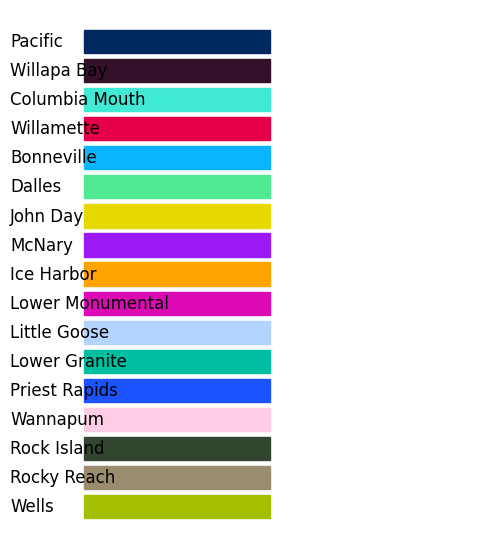

In [355]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


def plot_dam_colors(dam_colors):
    """
    Plot a list of dams and their corresponding colors.

    Parameters
    ----------
    dam_colors : dict
        Dictionary mapping dam names (str) to color hex codes (str).
    """
    # Create figure
    fig, ax = plt.subplots(figsize=(6, len(dam_colors) * 0.4))
    ax.axis("off")

    # Plot each dam name and its color swatch
    for i, (dam, color) in enumerate(dam_colors.items()):
        ax.add_patch(
            mpatches.Rectangle((0.4, len(dam_colors) - i - 1), 1, 0.8, color=color)
        )
        ax.text(0, len(dam_colors) - i - 0.6, dam, va="center", fontsize=12)

    ax.set_xlim(0, 2.5)
    ax.set_ylim(-0.5, len(dam_colors) + 0.5)
    plt.show()

# Example usage
DAM_COLORS = {
    "Pacific": "#01295f",
    "Willapa Bay": "#321129",
    "Columbia Mouth": "#41ead4",
    "Willamette": "#e60049",
    "Bonneville": "#0bb4ff",
    "Dalles": "#50e991",
    "John Day": "#e6d800",
    "McNary": "#9b19f5",
    "Ice Harbor": "#ffa300",
    "Lower Monumental": "#dc0ab4",
    "Little Goose": "#b3d4ff",
    "Lower Granite": "#00bfa0",
    "Priest Rapids": "#1a53ff",
    "Wannapum": "#fdcce5",
    "Rock Island": "#32462f",
    "Rocky Reach": "#9b8c6f",
    "Wells": "#a5be00",
}

plot_dam_colors(DAM_COLORS)

In [190]:
# Dams and edges
dams = [
    "Pacific",
    "Columbia Mouth",
    "Willapa Bay",
    "Bonneville",
    "Dalles",
    "Willamette",
    "McNary",
    "Ice Harbor",
    "John Day",
    "Lower Granite",
    "Lower Monumental",
    "Little Goose",
    "Rock Island",
    "Rocky Reach",
    "Wannapum",
    "Priest Rapids",
    "Wells",
]

edges = [
    ("Pacific", "Columbia Mouth"),
    ("Pacific", "Willapa Bay"),
    ("Columbia Mouth", "Bonneville"),
    ("Columbia Mouth", "Bonneville"),
    ("Willapa Bay", "Willamette"),
    ("Willapa Bay", "Bonneville"),
    ("Bonneville", "Dalles"),
    ("Dalles", "John Day"),
    ("John Day", "McNary"),
    ("McNary", "Ice Harbor"),
    ("Ice Harbor", "Lower Monumental"),
    ("Lower Monumental", "Little Goose"),
    ("Little Goose", "Lower Granite"),
    ("McNary", "Priest Rapids"),
    ("Priest Rapids", "Wannapum"),
    ("Wannapum", "Rock Island"),
    ("Rock Island", "Rocky Reach"),
    ("Rocky Reach", "Wells"),
]


digraph_fig = plot_digraph_rivers(dams, edges)
digraph_fig.show()

In [ ]:
# Create column map from species_dam_counts_yr
column_map = dict(zip(species_dam_counts_yr["LOCATION"], species_dam_counts_yr["DAM"]))


# Create directed graph (downstream-to-upstream)
G = nx.DiGraph()
G.add_edges_from(edges)

transitive_pairs = set()
for node1 in G.nodes():
    for node2 in G.nodes():
        if node1 != node2 and nx.has_path(G, node1, node2):
            if node1 in column_map.keys() and node2 in column_map.keys():
                transitive_pairs.add((column_map[node1], column_map[node2]))

print(f"Analyzing {len(transitive_pairs)} hierarchical pairs:")
for pair in sorted(transitive_pairs)[0:10]:
    print(pair)

Analyzing 58 hierarchical pairs:
('BON', 'IHR')
('BON', 'JDA')
('BON', 'LGR')
('BON', 'LGS')
('BON', 'LMN')
('BON', 'MCN')
('BON', 'PRD')
('BON', 'RIS')
('BON', 'RRH')
('BON', 'TDA')


In [ ]:
# species_dam_counts_select = species_dam_counts[
#     species_dam_counts.LOCATION.isin(["Bonneville", "Dalles"])
# ].copy()
# species_dam_counts_select.COUNT = np.where(
#     species_dam_counts_select.COUNT < 0, 0, species_dam_counts_select.COUNT
# )
# print(species_dam_counts_select.DAM.unique())

# avg_doy = species_dam_counts_select[species_dam_counts_select["YEAR"] == 2023][
#     ["DAM", "DOY", "COUNT"]
# ].copy()
# avg_doy = avg_doy.sort_values("DOY").reset_index(drop=True)

# color_map = {"BON": "blue", "MCN": "red"}

# fig = px.bar(
#     avg_doy,
#     x="DOY",
#     y="COUNT",
#     color="DAM",
#     barmode="overlay",
#     color_discrete_map=color_map,
# )
# fig.show()


# df = pd.pivot_table(avg_doy, index="DOY", columns="DAM", values="COUNT").reset_index()

# # Extract the time series
# doy = df["DOY"]
# bon = df["BON"]
# bon = bon.fillna(0)

# mcn = df["TDA"]
# mcn = mcn.fillna(0)

# # Set maximum lag for analysis
# max_lag = 50
# lags, corr = cross_correlation(bon, mcn, max_lag)

# # Find the lag with maximum correlation
# max_corr_idx = np.argmax(corr)
# max_corr_lag = lags[max_corr_idx]
# max_corr_value = corr[max_corr_idx]

# print(f"Maximum correlation: {max_corr_value:.2f} at lag {max_corr_lag} days")
# print("Positive lag indicates BON lags MCN; negative lag indicates BON leads MCN.")

# # Plot the time series
# plt.figure(figsize=(10, 6))
# plt.plot(doy, bon, label="BON", color="#1f77b4")
# plt.plot(doy, mcn, label="MCN", color="#ff7f0e")
# plt.xlabel("Day of Year (DOY)")
# plt.ylabel("Value")
# plt.title("BON and MCN Time Series")
# plt.legend()
# plt.grid(True)
# plt.show()

# # Plot the cross-correlation
# plt.figure(figsize=(10, 6))
# plt.plot(lags, corr, color="#2ca02c")
# plt.axvline(
#     x=max_corr_lag, color="r", linestyle="--", label=f"Max Corr at lag {max_corr_lag}"
# )
# plt.xlabel("Lag (Days)")
# plt.ylabel("Correlation Coefficient")
# plt.title("Cross-Correlation Function (BON vs. MCN)")
# plt.legend()
# plt.grid(True)
# plt.show()

# # Clip the dataset to DOY 76–365 (where both BON and MCN have significant activity)
# df_clipped = df[df["DOY"] >= 76].copy()

# # Check for NaNs
# if df_clipped[["BON", "TDA"]].isna().any().any():
#     print("NaNs detected. Imputing with zeros.")
#     df_clipped["BON"] = df_clipped["BON"].fillna(0.0)
#     df_clipped["TDA"] = df_clipped["TDA"].fillna(0.0)
# else:
#     print("No NaNs detected in BON or MCN.")

# # Extract the time series
# doy = df_clipped["DOY"]
# bon = df_clipped["BON"]
# mcn = df_clipped["TDA"]

# # Set maximum lag
# max_lag = 50
# lags, corr = cross_correlation(bon, mcn, max_lag)

# # Remove NaNs from correlation results for plotting
# valid_idx = ~np.isnan(corr)
# lags = lags[valid_idx]
# corr = np.array(corr)[valid_idx]

# # Find the lag with maximum correlation
# max_corr_idx = np.argmax(corr)
# max_corr_lag = lags[max_corr_idx]
# max_corr_value = corr[max_corr_idx]

# print(f"Maximum correlation: {max_corr_value:.2f} at lag {max_corr_lag} days")
# print("Positive lag indicates BON lags MCN; negative lag indicates BON leads MCN.")

# # Plot the time series
# plt.figure(figsize=(10, 6))
# plt.plot(doy, bon, label="BON", color="#1f77b4")
# plt.plot(doy, mcn, label="TDA", color="#ff7f0e")
# plt.xlabel("Day of Year (DOY)")
# plt.ylabel("Value")
# plt.title("BON and TDA Time Series (DOY 76–365)")
# plt.legend()
# plt.grid(True)
# plt.show()

# # Plot the cross-correlation
# plt.figure(figsize=(10, 6))
# plt.plot(lags, corr, color="#2ca02c")
# plt.axvline(
#     x=max_corr_lag, color="r", linestyle="--", label=f"Max Corr at lag {max_corr_lag}"
# )
# plt.xlabel("Lag (Days)")
# plt.ylabel("Correlation Coefficient")
# plt.title("Cross-Correlation Function (BON vs. MCN, DOY 76–365)")
# plt.legend()
# plt.grid(True)
# plt.show()

In [274]:
# Same lag with tighter window == probably somewhat robust... let's do it across all sites

In [316]:
# Extract the time series
def get_max_corr_lag(df, pair1, pair2):
    doy = df["DOY"]
    pair1_df = df[pair1]
    pair1_df = pair1_df.fillna(0)

    pair2_df = df[pair2]
    pair2_df = pair2_df.fillna(0)

    # Set maximum lag for analysis
    max_lag = 50
    lags, corr = cross_correlation(pair1_df, pair2_df, max_lag)
    max_corr_idx = np.argmax(corr)

    lookup = pd.DataFrame()
    lookup["PAIR"] = [f"{pair1}-{pair2}"]
    lookup["MAX_CORR_LAG"] = [lags[max_corr_idx]]
    lookup["MAX_CORR"] = [corr[max_corr_idx]]

    return lookup

In [323]:
species_dam_counts_select = species_dam_counts.copy()
species_dam_counts_select.COUNT = np.where(
    species_dam_counts_select.COUNT < 0, 0, species_dam_counts_select.COUNT
)

df = pd.pivot_table(
    species_dam_counts, index="DOY", columns="DAM", values="COUNT"
).reset_index()
df = df.fillna(0)

returned_vals = []
for pair in transitive_pairs:
    pair_corr = get_max_corr_lag(df, pair1=pair[0], pair2=pair[1])
    returned_vals.append(pair_corr)

returned_vals = pd.concat(returned_vals)

In [ ]:
returned_vals[returned_vals.PAIR.str.startswith("BON")].sort_values("MAX_CORR_LAG")

,PAIR,MAX_CORR_LAG,MAX_CORR
0,BON-WAN,-50,0.513251
0,BON-WEL,-50,0.818876
0,BON-RIS,-50,0.609571
0,BON-RRH,-50,0.706007
0,BON-TDA,2,0.974441
0,BON-LMN,5,0.688880
0,BON-IHR,5,0.716879
0,BON-JDA,6,0.945352
0,BON-LGS,6,0.677647
0,BON-LGR,8,0.696144


In [340]:
fig = px.line()
fig.add_scatter(x=df["DOY"], y=df["BON"], marker_color="green", name="BON")
fig.add_scatter(x=df["DOY"], y=df["TDA"], marker_color="blue", name="TDA")
fig.add_scatter(x=df["DOY"], y=df["JDA"], marker_color="teal", name="JDA")
fig.add_scatter(x=df["DOY"], y=df["IHR"], marker_color="orange", name="IHR")
fig.add_scatter(x=df["DOY"], y=df["LMN"], marker_color="red", name="LMN")
fig.show()

In [327]:
column_map

{'Bonneville': 'BON',
 'Dalles': 'TDA',
 'Willamette': 'WFA',
 'McNary': 'MCN',
 'Ice Harbor': 'IHR',
 'John Day': 'JDA',
 'Lower Granite': 'LGR',
 'Lower Monumental': 'LMN',
 'Little Goose': 'LGS',
 'Rock Island': 'RIS',
 'Rocky Reach': 'RRH',
 'Wannapum': 'WAN',
 'Priest Rapids': 'PRD',
 'Wells': 'WEL'}

In [326]:
# Create column map from species_dam_counts_yr
column_map = dict(zip(species_dam_counts_yr["LOCATION"], species_dam_counts_yr["DAM"]))

digraph_fig = plot_digraph_rivers(dams, edges)
digraph_fig.show()